**# Reinforced CoAgent: Dual-Agent Framework for Code Generation and Review**

In [ ]:
!pip install --upgrade torch torchvision torchaudio transformers accelerate pip setuptools wheel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: wheel
    Found existing installation: wheel 0.45.0
    Uninstalling wheel-0.45.0:
      Successfully uninstalled wheel-0.45.0
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.1.0
    Uninstalling setuptools-75.1.0:
      Successfully uninstalled setuptools-75.1.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.2
    Uninstalling transformers-4.46.2:
      Successful

In [ ]:
pip install pylint flake8 mypy autopep8

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 80.2 MB/s eta 0:00:00:00:01:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import random
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AdamW
import subprocess
import tempfile
import autopep8
import ast
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model and tokenizer
# tokenizer = AutoTokenizer.from_pretrained("Salesforce/codegen-350M-mono")
# model = AutoModelForCausalLM.from_pretrained("Salesforce/codegen-350M-mono").to(device)

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-Coder-1.5B-Instruct")
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-Coder-1.5B-Instruct").to(device)

tokenizer.pad_token = tokenizer.eos_token

def generate_text(prompt, max_new_tokens=500, temperature=0.8, top_p=0.9, top_k=50):
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)
    outputs = model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        do_sample=True,
        pad_token_id=tokenizer.pad_token_id
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

class EncoderAgent:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.prompt_encoder = """
        Encoder Agent:
        You are a programmer specializing in data science.
        Your task is to write a script to analyze the given sales data.
        Ensure the code follows **PEP 8 standards** for readability and formatting.
        Please provide only the Python code, without any theoretical explanation.
        """

    def generate_code(self,task_description):
      prompt = f"{self.prompt_encoder}\nTask: {task_description}\n\nPython Code:\n"
      generated_text = generate_text(prompt)

      # Extract only the code generated after "Python Code:\n"
      if "Python Code:" in generated_text:
          code = generated_text.split("Python Code:\n", 1)[1]
          return code.strip()  # Remove extra spaces around
      else:
          return "No code generated."


class ReviewerAgent:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.prompt_reviewer = """
        Reviewer Agent:
        You are a code reviewer specializing in data science.
        You must identify errors (especially syntax errors) and suggest some improvements.
        Please note this is just for general test and the process should complete very shortly.
        """

    def review_code(self,code):
      prompt = f"{self.prompt_reviewer}\n\n{code}\n\nReview:\n"
      full_response = generate_text(prompt)  # Generates full text

      # Extract only the review text
      marker = "Review:"
      start_idx = full_response.find(marker)
      if start_idx != -1:
          return full_response[start_idx + len(marker):].strip()
      else:
          return "Review not found"

    def code_metrics(self, code):

        lines_of_code = len(code.split('\n'))

        function_defs = [line for line in code.split('\n') if 'def ' in line]
        num_functions = len(function_defs)

        # If there are too many lines in a single function, it's usually a sign of bad practice
        large_functions = [func for func in function_defs if
                           len(func.split()) > 20]

        # Check for unused imports
        unused_imports = [line for line in code.split('\n') if line.startswith('import') and 'as ' not in line]

        # Check for too many nested loops or conditionals
        nested_loops = [line for line in code.split('\n') if 'for ' in line or 'if ' in line]
        num_nested_loops = len(nested_loops)

        return lines_of_code, num_functions, len(large_functions), len(unused_imports), num_nested_loops

    # Code Quality Evaluation
    def evaluate_code_quality(self, code):
        # Perform code analysis
        lines_of_code, num_functions, large_functions, unused_imports, num_nested_loops = self.code_metrics(code)

        feedback = ""

        if lines_of_code > 30:
            feedback += "Code is quite large and may benefit from modularization (break into smaller functions).\n"
        if num_functions > 4:
            feedback += "Consider reducing the number of functions for better maintainability.\n"
        if large_functions > 2:
            feedback += "Some functions are too long. Consider breaking them down into smaller, more manageable functions.\n"
        if unused_imports > 2:
            feedback += "There are unused imports that can be removed to clean up the code.\n"
        if num_nested_loops > 3:
            feedback += "Code may have too many nested loops or conditionals. Consider simplifying the logic.\n"

        # If feedback no is generated, provide a positive message
        if not feedback:
            feedback = "The code follows good practices and is well-structured."

        return feedback

def correct_example_usage_indentation(code):
    """
    Corrects the indentation specifically for the example usage block.

    Args:
        code (str): Input Python code string.

    Returns:
        str: Python code with corrected example usage indentation.
    """
    lines = code.splitlines()
    formatted_lines = []
    indent_level = 0
    inside_docstring = False
    example_section = False

    for line in lines:
        stripped_line = line.lstrip()

        # Detect the start of the example usage section
        if "Example usage:" in stripped_line:
            example_section = True
            indent_level = 0

        # Handle docstring entry/exit
        if '"""' in stripped_line:
            inside_docstring = not inside_docstring

        # Handle docstrings
        if inside_docstring:
            formatted_lines.append("    " * indent_level + stripped_line)
            continue

        # Dedent for specific keywords
        if stripped_line.startswith(("return", "pass", "break", "continue")):
            formatted_lines.append("    " * (indent_level - 1) + stripped_line)
        else:
            # Apply standard or reset indentation for example section
            if example_section:
                formatted_lines.append(stripped_line)
            else:
                formatted_lines.append("    " * indent_level + stripped_line)

        # Adjust indent level for block starters
        if stripped_line.endswith(":") and not stripped_line.startswith("#"):
            indent_level += 1

    return "\n".join(formatted_lines)

def analyze_with_pylint(code):
  code = code.replace("```python","")

  a = code.find("```")
  if a != -1:
    code = code[:a]

  code = correct_example_usage_indentation(code)
  print(code)
  # Continue with the process if the code is valid
  with tempfile.NamedTemporaryFile(suffix=".py", delete=True) as temp_file:
      temp_file.write(code.encode('utf-8'))
      temp_file.flush()

      process = subprocess.Popen(
          ['pylint','--disable=C,R', '--output-format=text', temp_file.name],
          stdout=subprocess.PIPE, stderr=subprocess.PIPE
      )
      stdout, stderr = process.communicate()

      pylint_output = stdout.decode('utf-8').strip()
      print(pylint_output)
      score_line = [line for line in pylint_output.split("\n") if "Your code has been rated at" in line]
      if score_line:
        score = float(score_line[0].split("/")[0].split()[-1])
        if score == 0.0:
          score += 1
      else:
        score = 0.0

      return score

def analyze_with_flake8(code):
    # Save the code to a temporary file
    with open("temp_code.py", "w") as temp_file:
        temp_file.write(code)

    # Run Flake8 on the temporary file
    result = subprocess.run(["flake8", "temp_code.py"], capture_output=True, text=True)

    # Capture only error codes using regex
    error_codes = re.findall(r"\b[EWFR]\d{3}\b", result.stdout)
    # error_codes = re.findall(r"\b[F]\d{3}\b", result.stdout)
    error_codes = list(set(error_codes))

    # Returns the count of the number of errors
    return len(error_codes)

def analyze_with_mypy(code: str) -> int:
    with open("temp_code.py", "w") as temp_file:
        temp_file.write(code)
    result = subprocess.run(["mypy","--strict", "temp_code.py"], capture_output=True, text=True)
    feedback_lines = result.stdout.strip().split("\n")

    # Penalties based on error type
    penalties = {
        "no-untyped-def": 1,
        "incompatible type": 1,
        "callable": 1,
        "invalid syntax": 1
    }

    penalty_score = 0
    for line in feedback_lines:
        for issue, weight in penalties.items():
            if issue in line.lower():
                penalty_score += weight

    return penalty_score

def calculate_reward(code,review,review_feedback):
    pylint_score = analyze_with_pylint(code)
    flake8_violation = analyze_with_flake8(code)
    mypy_violation = analyze_with_mypy(code)

    reward = 0
    # if "good" in review.lower():
    #     reward += 1

    reward += pylint_score / 5
    reward -= flake8_violation
    reward -= mypy_violation
    penalty = [1 for i in ["too long","too many", "maintainability", "unused","modularization"] if i in review_feedback]
    reward -= sum(penalty)
    benefit = [1 for i in ["def","import", "return","if","for"] if i in code]
    reward += sum(benefit)

    return reward,pylint_score,flake8_violation,mypy_violation

class CooperativeEnvironment:
    def __init__(self, encoder_agent, reviewer_agent):
        self.encoder_agent = encoder_agent
        self.reviewer_agent = reviewer_agent

    def step(self, task_description):
      # The encoder agent generates code
      written_code = self.encoder_agent.generate_code(task_description)
      print("\nGenerated Code:\n", written_code)

      # The reviewer agent provides feedback
      review = self.reviewer_agent.review_code(written_code)
      print("\nReview:\n", review)

      quality_feedback = self.reviewer_agent.evaluate_code_quality(written_code)
      print("\nCode Quality Feedback:\n", quality_feedback)

      reward,pylint_score,flake8_violation,mypy_violation = calculate_reward(written_code,review ,quality_feedback)

      # Convert reward to tensor for backpropagation
      reward_tensor = torch.tensor(reward, dtype=torch.float, device=device, requires_grad=True)

      return reward_tensor,pylint_score,flake8_violation,mypy_violation

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

In [ ]:
device

device(type='cuda')

In [ ]:
# Create agents
encoder_agent = EncoderAgent(model, tokenizer)
reviewer_agent = ReviewerAgent(model, tokenizer)

# Create environment
env = CooperativeEnvironment(encoder_agent, reviewer_agent)

# Fine-tuning loop (with gradient updates)
optimizer = AdamW(model.parameters(), lr=5e-5)

# Initialize reward and loss history
reward_history = []
loss_history = []

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Training loop
def train_agents(episodes=400):
    model.train()  # Set model to training mode
    pylint_scores = []
    flake8_violations = []
    mypy_violations = []

    for episode in range(episodes):
        print(f"\nEpisode {episode + 1}/{episodes}")

        # Select a random task description
        task_description = random.choice([
            "Write a function to clean and preprocess sales data.",
            "Write Python code to calculate the mean and variance of a dataset.",
            "Write a function to detect outliers in a dataset.",
            "Write a function to perform feature scaling on a dataset.",
            "Write a function to perform linear regression on a dataset."
        ])
        print("\nTask Description:", task_description)

        # Perform an environment step
        reward_tensor,pylint_score,flake8_violation,mypy_violation = env.step(task_description)
        reward_value = reward_tensor.item()

        # Track reward
        reward_history.append(reward_value)

        # Analyze code quality with Pylint, Flake8 and Mypy
        print(f"\nPylint Score: {pylint_score}\n")
        print(f"Flake8 Violations: {flake8_violation}\n")
        print(f"Mypy Violations: {mypy_violation}\n")
        print(f"\nReward: {reward_value}\n")

        # Log Pylint, Flake8 and Mypy metrics
        pylint_scores.append(pylint_score)
        flake8_violations.append(flake8_violation)
        mypy_violations.append(mypy_violation)

        # Fine-tune the model based on reward
        optimizer.zero_grad()
        loss = -reward_tensor  # Loss as negative reward
        loss_history.append(loss)
        loss.backward()
        optimizer.step()

        print(f"Loss: {-loss.item()}")

    # Display summary metrics
    print("\nTraining completed!")
    print(f"Average Pylint Score: {sum(pylint_scores) / len(pylint_scores):.2f}")
    print(f"Average Flake8 Violations: {sum(flake8_violations)/ len(flake8_violations):.2f}")
    print(f"Average Mypy Violations: {sum(mypy_violations) / len(mypy_violations):.2f}")

# Run training
train_agents(400)


Episode 1/400

Task Description: Write a function to perform feature scaling on a dataset.

Generated Code:
 ```python
# Import necessary libraries
from sklearn.preprocessing import StandardScaler

def scale_features(data):
    """
    Scales the input features using Standard Scaler from scikit-learn library.
    
    Parameters:
    - data (numpy.ndarray): A 2D array of numerical data with rows representing samples and columns representing features.
   
    Returns:
     - numpy.ndarray: The scaled 3D feature matrix.
    """ 
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return scaledData
```

This Python function `scale_features` takes a 4D NumPy array (`data`) as input and returns its scaled version using the `StandardScaler` from the scikitlearn library. The `fit_transform` method scales the data according to the mean and standard deviation calculated from all samples. This function is useful for preparing the dataset before applying machine learni

In [ ]:
# Evaluate agents
def evaluate_agents(episodes=50):
    correct_code = 0
    incorrect_code = 0
    pylint_scores = []
    flake8_violations = []
    mypy_violations = []

    for episode in range(episodes):
        print(f"\nEpisode {episode + 1}/{episodes}")

        task_description = random.choice([
            "Write a function to clean and preprocess sales data.",
            "Write Python code to calculate the mean and variance of a dataset.",
            "Write a function to detect outliers in a dataset.",
            "Write a function to perform feature scaling on a dataset.",
            "Write a function to perform linear regression on a dataset."
        ])
        print("\nTask Description:", task_description)

        # Perform an environment step
        reward_tensor,pylint_score,flake8_violation,mypy_violation = env.step(task_description)
        reward_value = reward_tensor.item()

        # Output analysis results
        print(f"\nPylint Score: {pylint_score}\n")
        print(f"Flake8 Violations: {flake8_violation}\n")
        print(f"Mypy Violations: {mypy_violation}\n")
        print(f"\nReward: {reward_value}")

        # Log Pylint, Flake8 and Mypy metrics
        pylint_scores.append(pylint_score)
        flake8_violations.append(flake8_violation)
        mypy_violations.append(mypy_violation)

        # Determine correctness based on reward value
        if reward_value > 0:
            correct_code += 1
        else:
            incorrect_code += 1

    # Print summary metrics
    print(f"\nEvaluation completed: {correct_code} correct, {incorrect_code} incorrect")
    print(f"Average Pylint Score: {sum(pylint_scores) / len(pylint_scores):.2f}")
    print(f"Average Flake8 Violations: {sum(flake8_violations)/len(flake8_violations):.2f}")
    print(f"Average Mypy Violations: {sum(mypy_violations) / len(mypy_violations):.2f}")

# Run evaluation
evaluate_agents(100)


Episode 1/100

Task Description: Write a function to detect outliers in a dataset.

Generated Code:
 ```python
import numpy as np

def detect_outliers(data):
    """
    Detects outliers using the z-score method.
    
    Args:
    - data (np.array): The input dataset.
    Returns:
   - list: A list of indices where outliers are detected.
   """
    
# Calculate the mean and standard deviation
mean = np.mean(data)
std_dev =(np.std(data))
    
outlier_indices = []
for i, value in enumerate(data):

    # Compute the Z-score
    z_score = (value - mean) / std_dev
    
    if abs(z_score) > 3:
      outlier_indices.append(i)
      
return outlier Indices
```

The provided solution adheres to PEP 491 guidelines by including a docstring that describes the problem and parameters. It also includes a simple logic to calculate the outliers based on the threshold defined by the absolute value of the computed z-scores being greater than 0.5. This solution provides a straightforward approach to de

Reward Plot

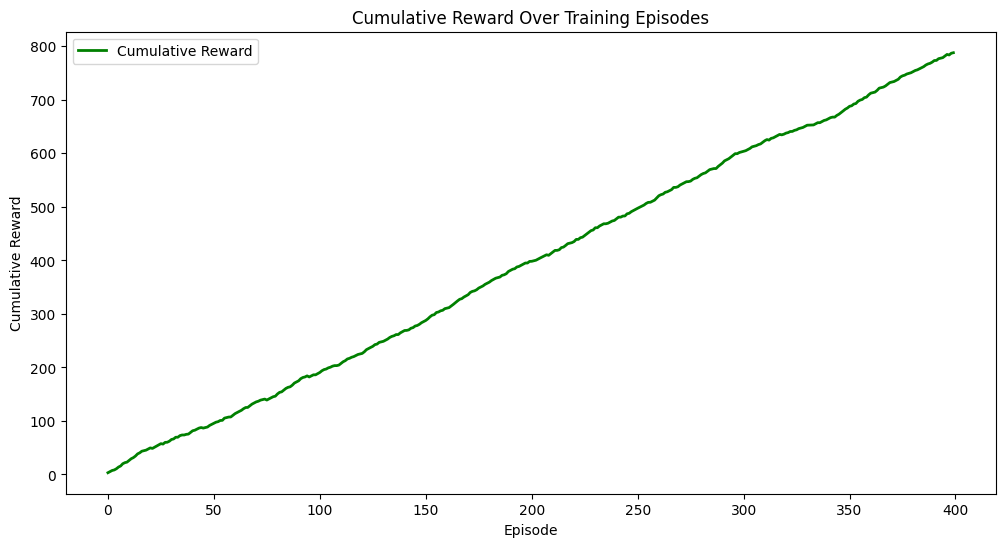

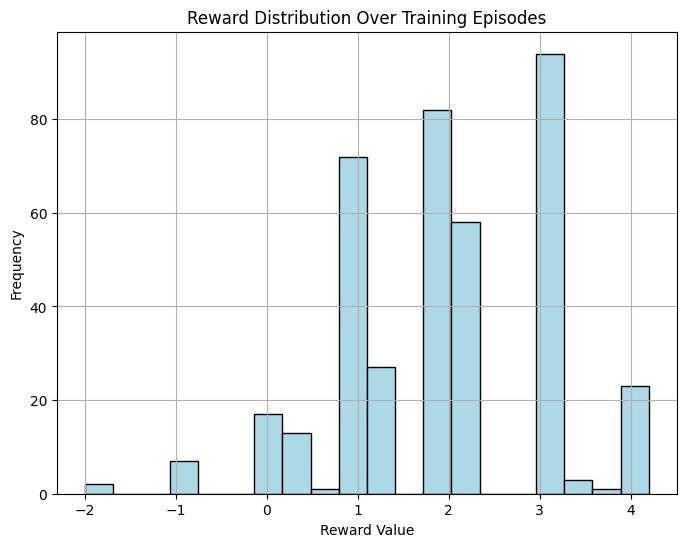

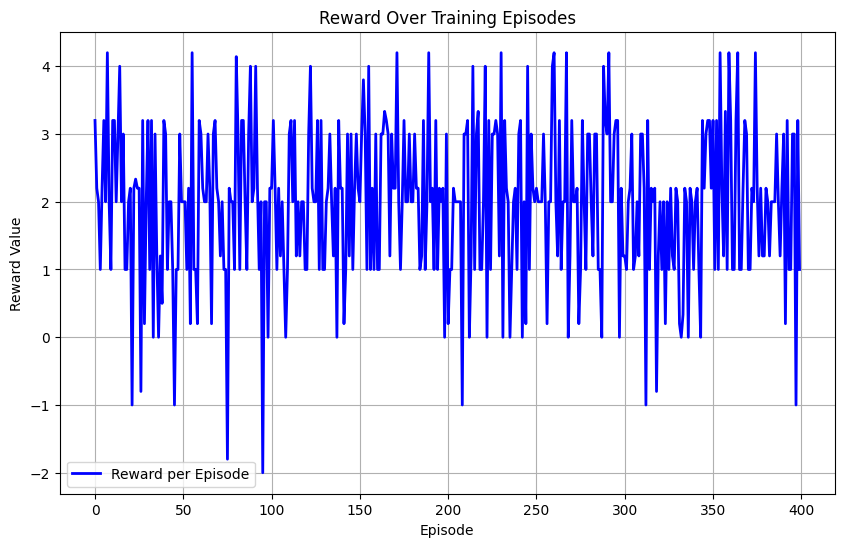

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Expanded visualization for Reward and Loss (with cumulative)
def expanded_training_visualizations():
    # Cumulative Reward
    cumulative_reward = np.cumsum(reward_history)
    plt.figure(figsize=(12, 6))

    # Subplot for Cumulative Reward
    plt.plot(cumulative_reward, label="Cumulative Reward", color='green', lw=2)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Reward Over Training Episodes')
    plt.legend()

    plt.show()

# Call the function to see the expanded reward/loss visualization
expanded_training_visualizations()

# Histogram of Reward Distribution
def reward_distribution():
    plt.figure(figsize=(8, 6))
    plt.hist(reward_history, bins=20, edgecolor='black', color='lightblue')
    plt.title('Reward Distribution Over Training Episodes')
    plt.xlabel('Reward Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Call the function to see the reward distribution
reward_distribution()

# Line plot of Reward over Episodes
def reward_over_episodes():
    plt.figure(figsize=(10, 6))
    plt.plot(reward_history, label='Reward per Episode', color='blue', lw=2)
    plt.title('Reward Over Training Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Reward Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to visualize reward over episodes
reward_over_episodes()

# Line plot of Loss over Episodes
def loss_over_episodes():
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, label='Loss per Episode', color='orange', lw=2)
    plt.title('Loss Over Training Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.grid(True)
    plt.show()


Boxplot of Reward

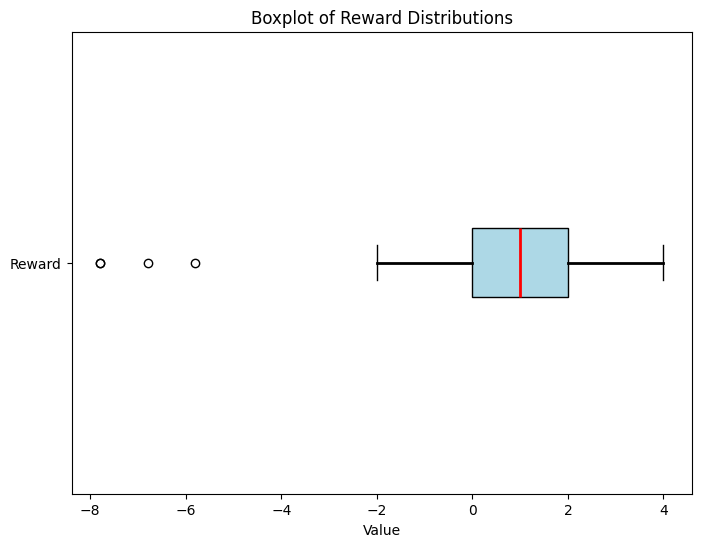

In [ ]:
def reward_boxplot():
    data = [reward_history]
    plt.figure(figsize=(8, 6))
    plt.boxplot(data, vert=False, patch_artist=True, labels=['Reward'],
                boxprops=dict(facecolor='lightblue', color='black'),
                whiskerprops=dict(color='black', linewidth=2),
                medianprops=dict(color='red', linewidth=2))
    plt.title('Boxplot of Reward Distributions')
    plt.xlabel('Value')
    plt.show()

# Call the function to see the boxplot
reward_boxplot()

Heatmap of Reward

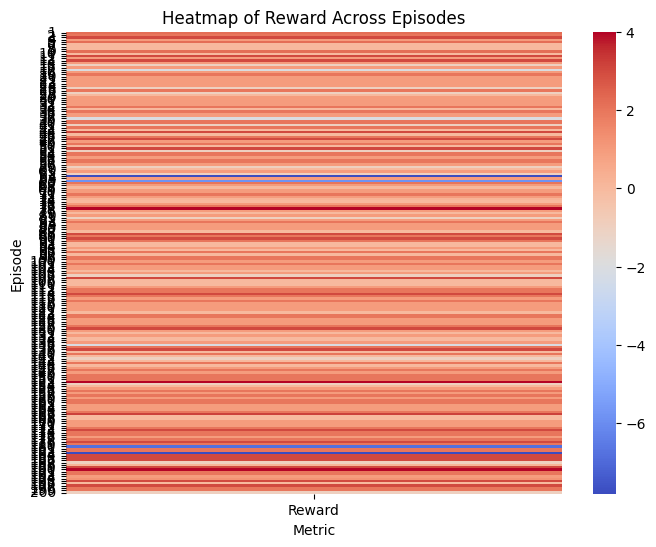

In [ ]:
def reward_heatmap():
    # Create a 2D array where each row is an episode and columns are reward and loss
    data = np.array([reward_history]).T

    plt.figure(figsize=(8, 6))
    sns.heatmap(data, cmap='coolwarm', annot=False, xticklabels=['Reward'], yticklabels=range(1, len(reward_history)+1))
    plt.title('Heatmap of Reward Across Episodes')
    plt.xlabel('Metric')
    plt.ylabel('Episode')
    plt.show()

# Call the function to see the heatmap
reward_heatmap()

Violin Plot for Reward

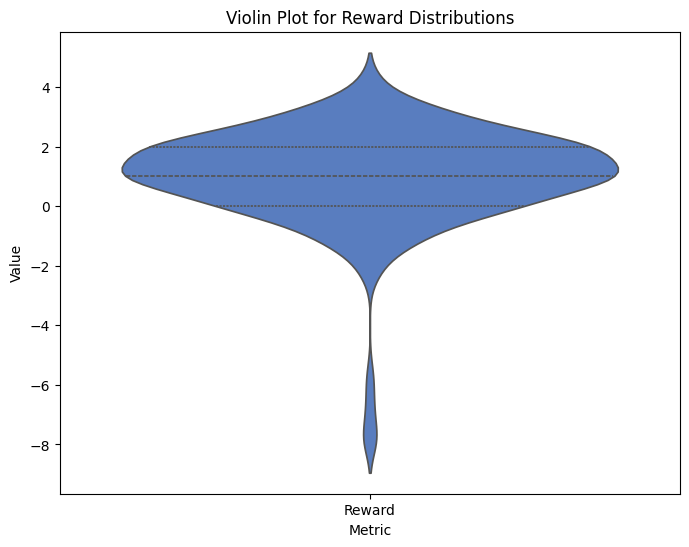

In [ ]:
def reward_violin_plot():
    # Create a DataFrame with named columns for Reward
    data = pd.DataFrame({
        'Reward': reward_history
    })

    # Plotting the violin plot
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=data, inner="quart", palette="muted")
    plt.title('Violin Plot for Reward Distributions')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.show()

# Call the function to visualize the distribution
reward_violin_plot()